[591.8, 607.6, 597.6, 584.6, 582.0, 596.2]
Using 3d array processing as lat, lon, and elevation were provided.
[[ 0.01203378  0.05675638  0.0074537  -0.04265749 -0.03699895  0.00341258]
 [ 0.05757267 -0.00817152 -0.04772992 -0.03157196  0.02748655  0.00241418]
 [-0.0015      0.0143      0.0043     -0.0087     -0.0113      0.0029    ]]


c:\Users\csaunders-shultz\Documents\GitHub\lts_array\lts_array\classes\lts_data_class.py:193: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


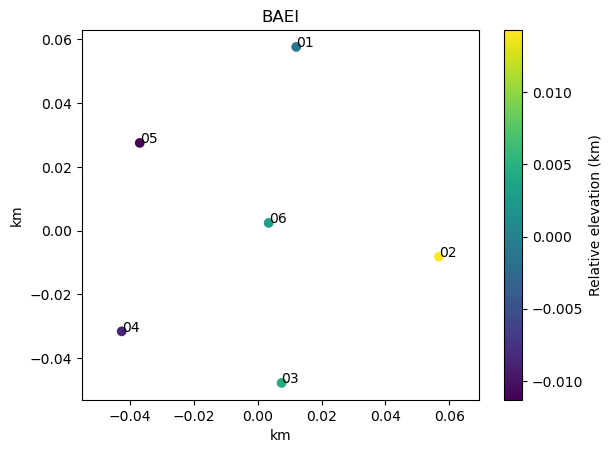

In [13]:
# lts testing
import lts_array
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime as UTC


#Tools to test
#from lts_array.classes.lts_data_class import DataBin
#lts_array.classes.lts_classes.OLSEstimator
#lts_array.classes.lts_classes.LTSEstimator

#get stream for testing
NET = "AV"
STA = "BAEI"
LOC = "*"
CHAN = "HDF"
#START = UTC("2023-07-14 01:02:44") - 20
#END = START + 60
START = UTC("2025-09-06 23:30:30") #Can be run anytime after ~4pm AKST on thursday
END = UTC("2025-09-06 23:32:30")
client = Client("IRIS")
st = client.get_waveforms(NET, STA, LOC, CHAN, START, END, attach_response=True)
st.merge(fill_value="latest")
st.trim(START, END, pad="true", fill_value=0)
st.sort()
st.remove_sensitivity()
# Filter the data
st.filter("bandpass", freqmin=1, freqmax=20, corners=2, zerophase=True)
st.taper(max_percentage=0.05)
st[0].data *= -1
inv = client.get_stations(
    network=NET,
    station=STA,
    channel=CHAN,
    location=LOC,
    starttime=START,
    endtime=END,
    level="channel",
)
lat_list = []
lon_list = []
elevation_list = []  # meters
staname = []
for network in inv:
    for station in network:
        for channel in station:
            lat_list.append(channel.latitude)
            lon_list.append(channel.longitude)
            elevation_list.append(channel.elevation)
            staname.append(channel.code)

print(elevation_list)

data = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.7)
data.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)

data.plot_array_coordinates()
print(data.rij)

In [6]:
print(data.rij.shape)

import numpy as np

def fit_plane(rij):
    """
    Fit a plane to 3D points and return slope and direction.
    
    Parameters
    ----------
    rij : np.ndarray
        Array of shape (3, n_points), rows are [x, y, z].

    Returns
    -------
    plane_coeff : tuple
        (a, b, c) for plane z = a*x + b*y + c
    slope_deg : float
        Slope angle from horizontal (degrees)
    aspect_deg : float
        Direction of steepest descent (degrees from x-axis / East)
    """
    X = rij[0,:]
    Y = rij[1,:]
    Z = rij[2,:]

    # Fit plane Z = a*X + b*Y + c
    A = np.column_stack((X, Y, np.ones_like(X)))
    coeff, _, _, _ = np.linalg.lstsq(A, Z, rcond=None)
    a, b, c = coeff

    # Normal vector
    normal = np.array([-a, -b, 1.0])
    normal /= np.linalg.norm(normal)

    # Slope in degrees
    slope_deg = np.arccos(normal[2]) * 180 / np.pi

    # Aspect / direction in degrees
    aspect_deg = (np.arctan2(normal[1], normal[0]) * 180 / np.pi + 360) % 360

    return (a, b, c), slope_deg, aspect_deg

# Example usage:
# rij = np.array([[x1, x2, ...], [y1, y2, ...], [z1, z2, ...]])
plane_coeff, slope, aspect = fit_plane(data.rij)
print(plane_coeff, slope, aspect)


(3, 6)
(0.2474628340497113, -0.0660131612541008, -3.731861907103058e-17) 14.365593447574948 165.0635956243832


Using 2D array processing as only lat and lon were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
Using 3d array processing as lat, lon, and elevation were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
Timesteps are equal --> True
Lts_vel are equal --> False
tau are equal --> True
data.rij are equal --> False
xij are equal --> False
xij_mad are equal --> False


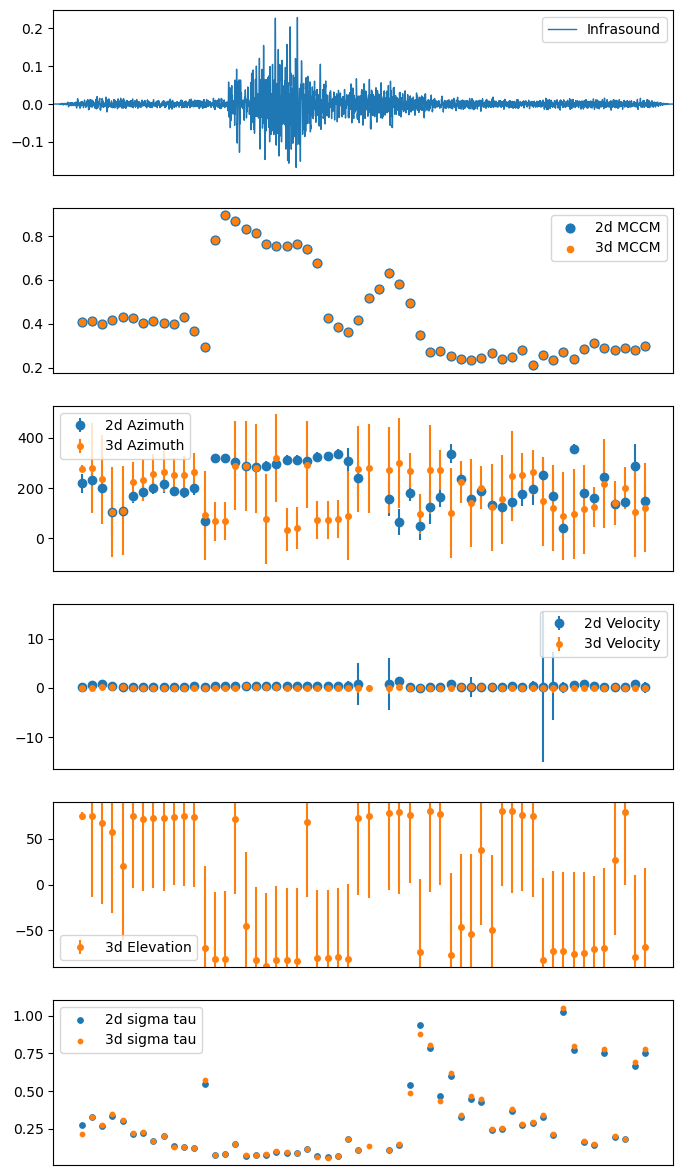

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#First, make sure that the 2d and 3d models return the same results
#They return different results so something is happening even before we get to solve
#Testing reveals tau are equal, so correlate produces the same result

#Check 2d
data2 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data2.build_data_arrays(st, lat_list, lon_list, remove_elements=None)# rij)
ltsva2 = lts_array.classes.OLSEstimator(data2)
ltsva2.correlate(data2)
ltsva2.solve(data2)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva2.lts_vel, ltsva2.lts_baz, ltsva2.t, ltsva2.mdccm, ltsva2.stdict)
#print(ltsva.lts_vel)

#Check 3d
data3 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data3.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)
ltsva3 = lts_array.classes.OLSEstimator(data3)
ltsva3.correlate(data3)
ltsva3.solve_3d(data3)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva3.lts_vel, ltsva3.lts_baz, ltsva3.t, ltsva3.mdccm, ltsva3.stdict)
#print(ltsva.lts_vel)

#testing
print(f"Timesteps are equal --> {np.array_equal(ltsva2.t, ltsva3.t)}")
print(f"Lts_vel are equal --> {np.array_equal(ltsva2.lts_vel, ltsva3.lts_vel)}")
print(f"tau are equal --> {np.array_equal(ltsva2.tau, ltsva3.tau)}")

print(f"data.rij are equal --> {np.array_equal(data2.rij, data3.rij)}") # distance from mean point in km
print(f"xij are equal --> {np.array_equal(ltsva2.xij, ltsva3.xij)}") # relative sensor locations for all pairs
print(f"xij_mad are equal --> {np.array_equal(ltsva2.xij_mad, ltsva3.xij_mad)}") #relative sensor locations, 

#Plot actual results
fig, axs = plt.subplots(nrows=6, figsize=(8,15))
t = ltsva2.t

#data
axs[0].plot(st[0], lw=1, label='Infrasound')
axs[0].set_xlim((0,len(st[0])))

#mccm
axs[1].scatter(t, ltsva2.mdccm, s=40, label='2d MCCM')
axs[1].scatter(t, ltsva3.mdccm, s=20, label='3d MCCM')

#azimuth
axs[2].errorbar(t, ltsva2.lts_baz, yerr=ltsva2.conf_int_baz, fmt ='o',markersize=6, label='2d Azimuth')
axs[2].errorbar(t, ltsva3.lts_baz, yerr=ltsva3.conf_int_baz, fmt ='o',markersize=4, label='3d Azimuth')

#Velocity
axs[3].errorbar(t, ltsva2.lts_vel, yerr=ltsva2.conf_int_vel, fmt ='o',markersize=6, label='2d Velocity')
axs[3].errorbar(t, ltsva3.lts_vel, yerr=ltsva3.conf_int_vel, fmt ='o',markersize=4, label='3d Velocity')#should be... lower? than 2d

#Elevation
#axs[4].scatter(t, ltsva3.lts_elev, s=10, label='3d Elevation')
axs[4].errorbar(t, ltsva3.lts_elev, yerr=ltsva3.conf_int_elev, fmt ='o',markersize=4, label='3d Elevation', c=plt.get_cmap("tab10")(1))
axs[4].set_ylim((-90,90))

#sigma tau
axs[5].scatter(t, ltsva2.sigma_tau, s=15, label='2d sigma tau')
axs[5].scatter(t, ltsva3.sigma_tau, s=10, label='3d sigma tau')


for ax in axs:
    ax.legend()
    ax.set_xticks(())


Using 2D array processing as only lat and lon were provided.
Using 3d array processing as lat, lon, and elevation were provided.


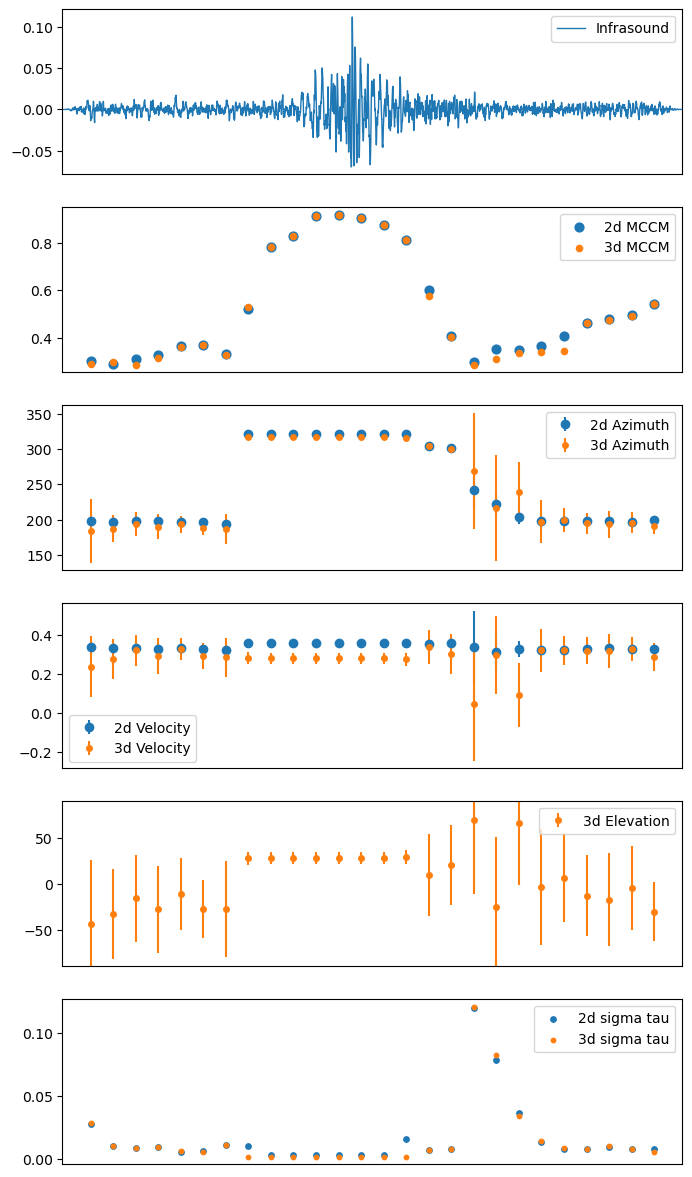

In [3]:
#NOW, try LTSEstimator

import numpy as np
import matplotlib.pyplot as plt
#First, make sure that the 2d and 3d models return the same results
#They return different results so something is happening even before we get to solve
#Testing reveals tau are equal, so correlate produces the same result

#Check 2d
data2 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.75)
data2.build_data_arrays(st, lat_list, lon_list, remove_elements=None)# rij)
ltsva2 = lts_array.classes.LTSEstimator(data2)
ltsva2.correlate(data2)
ltsva2.solve(data2)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva2.lts_vel, ltsva2.lts_baz, ltsva2.t, ltsva2.mdccm, ltsva2.stdict)
#print(ltsva.lts_vel)

#Check 3d
data3 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.75)
data3.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)
ltsva3 = lts_array.classes.LTSEstimator(data3)
ltsva3.correlate(data3)
ltsva3.solve_3d(data3)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva3.lts_vel, ltsva3.lts_baz, ltsva3.t, ltsva3.mdccm, ltsva3.stdict)


to_plot=True
if to_plot:
    #Plot actual results
    fig, axs = plt.subplots(nrows=6, figsize=(8,15))
    t = ltsva2.t

    #data
    axs[0].plot(st[0], lw=1, label='Infrasound')
    axs[0].set_xlim((0,len(st[0])))

    #mccm
    axs[1].scatter(t, ltsva2.mdccm, s=40, label='2d MCCM')
    axs[1].scatter(t, ltsva3.mdccm, s=20, label='3d MCCM')

    #azimuth
    axs[2].errorbar(t, ltsva2.lts_baz, yerr=ltsva2.conf_int_baz, fmt ='o',markersize=6, label='2d Azimuth')
    axs[2].errorbar(t, ltsva3.lts_baz, yerr=ltsva3.conf_int_baz, fmt ='o',markersize=4, label='3d Azimuth')

    #Velocity
    axs[3].errorbar(t, ltsva2.lts_vel, yerr=ltsva2.conf_int_vel, fmt ='o',markersize=6, label='2d Velocity')
    axs[3].errorbar(t, ltsva3.lts_vel, yerr=ltsva3.conf_int_vel, fmt ='o',markersize=4, label='3d Velocity')#should be... lower? than 2d

    #Elevation
    #axs[4].scatter(t, ltsva3.lts_elev, s=10, label='3d Elevation')
    axs[4].errorbar(t, ltsva3.lts_elev, yerr=ltsva3.conf_int_elev, fmt ='o',markersize=4, label='3d Elevation', c=plt.get_cmap("tab10")(1))
    axs[4].set_ylim((-90,90))

    #sigma tau
    axs[5].scatter(t, ltsva2.sigma_tau, s=15, label='2d sigma tau')
    axs[5].scatter(t, ltsva3.sigma_tau, s=10, label='3d sigma tau')


    for ax in axs:
        ax.legend()
        ax.set_xticks(())


Using 2D array processing as only lat and lon were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
Using 3d array processing as lat, lon, and elevation were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
Using 2D array processing as only lat and lon were provided.
Using 3d array processing as lat, lon, and elevation were provided.


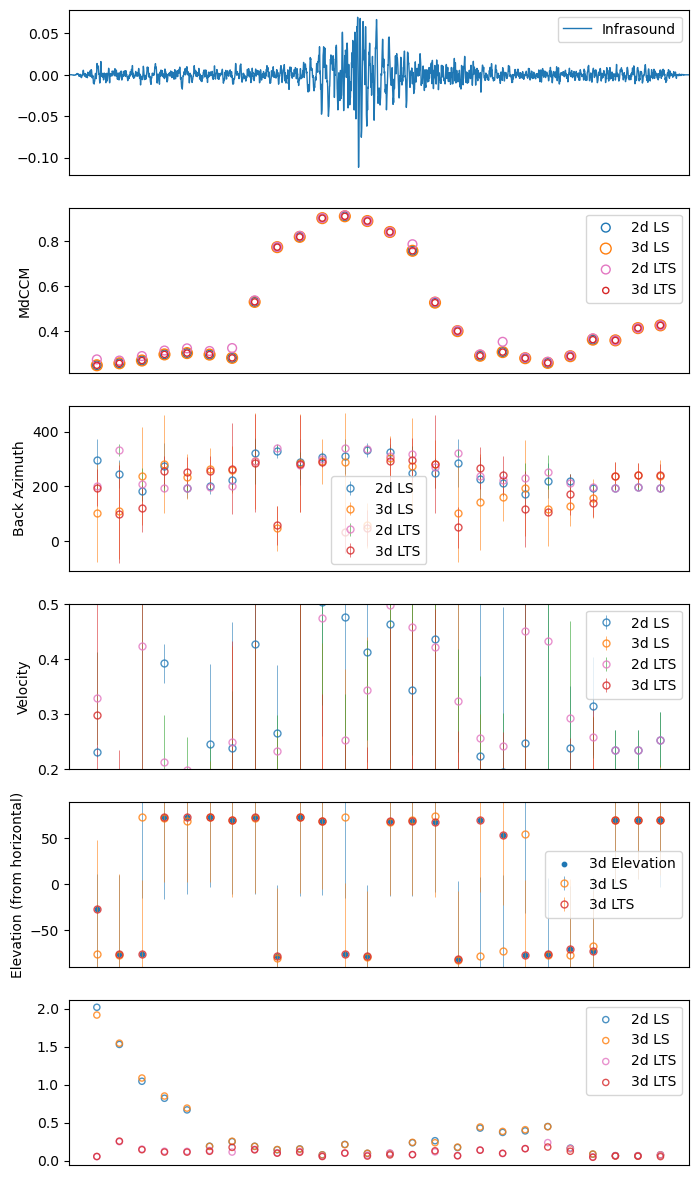

In [12]:
#First, solve LS case (alpha=1)
data2_alpha1 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data2_alpha1.build_data_arrays(st, lat_list, lon_list, remove_elements=None)# rij)
data3_alpha1 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data3_alpha1.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)

ls2 = lts_array.classes.OLSEstimator(data2_alpha1)
ls2.correlate(data2_alpha1)
ls2.solve(data2_alpha1)

ls3 = lts_array.classes.OLSEstimator(data3_alpha1)
ls3.correlate(data3_alpha1)
ls3.solve_3d(data3_alpha1)

#Next solve LTS cases (alpha=0.75)
#Check 2d
data2 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.75)
data2.build_data_arrays(st, lat_list, lon_list, remove_elements=None)# rij)
data3 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.75)
data3.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)

ltsva2 = lts_array.classes.LTSEstimator(data2)
ltsva2.correlate(data2)
ltsva2.solve(data2)

ltsva3 = lts_array.classes.LTSEstimator(data3)
ltsva3.correlate(data3)
ltsva3.solve_3d(data3)

to_plot=True
if to_plot:
    # Control variables
    line_w = 1
    err_w = 0.5
    alpha = 0.8
    cls = ['C0', 'C1', 'C6', 'C3']

    #Plot actual results
    fig, axs = plt.subplots(nrows=6, figsize=(8,15))
    t = ltsva2.t

    #data
    axs[0].plot(st[0], lw=1, label='Infrasound')
    axs[0].set_xlim((0,len(st[0])))

    #mccm
    axs[1].scatter(t, ls2.mdccm, s=40,    facecolors='none', edgecolors='C0', linewidths=line_w, label='2d LS' )
    axs[1].scatter(t, ls3.mdccm, s=60,    facecolors='none', edgecolors='C1', linewidths=line_w, label='3d LS' )
    axs[1].scatter(t, ltsva2.mdccm, s=40, facecolors='none', edgecolors=cls[2], linewidths=line_w, label='2d LTS')
    axs[1].scatter(t, ltsva3.mdccm, s=20, facecolors='none', edgecolors='C3', linewidths=line_w, label='3d LTS')
    axs[1].set_ylabel('MdCCM')

    #azimuth
    axs[2].errorbar(t, ls2.lts_baz, yerr=ls2.conf_int_baz, fmt ='o', mfc='none', mec='C0', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='2d LS' )
    axs[2].errorbar(t, ls3.lts_baz, yerr=ls3.conf_int_baz, fmt ='o', mfc='none', mec='C1', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LS' )
    axs[2].errorbar(t, ltsva2.lts_baz, yerr=ltsva2.conf_int_baz, fmt ='o', mfc='none', mec=cls[2], mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='2d LTS')
    axs[2].errorbar(t, ltsva3.lts_baz, yerr=ltsva3.conf_int_baz, fmt ='o', mfc='none', mec='C3', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LTS')
    axs[2].set_ylabel('Back Azimuth')

    #Velocity
    axs[3].errorbar(t, ls2.lts_vel, yerr=ls2.conf_int_vel, fmt ='o', mfc='none', mec='C0', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='2d LS' )
    axs[3].errorbar(t, ls3.lts_vel, yerr=ls3.conf_int_vel, fmt ='o', mfc='none', mec='C1', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LS' )
    axs[3].errorbar(t, ltsva2.lts_vel, yerr=ltsva2.conf_int_vel, fmt ='o', mfc='none', mec=cls[2], mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='2d LTS')
    axs[3].errorbar(t, ltsva3.lts_vel, yerr=ltsva3.conf_int_vel, fmt ='o', mfc='none', mec='C3', mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LTS')
    axs[3].set_ylabel("Velocity")
    axs[3].set_ylim(0.2, 0.5)

    #Elevation
    axs[4].scatter(t, ltsva3.lts_elev, s=10, label='3d Elevation')
    axs[4].errorbar(t, ls3.lts_elev, yerr=ls3.conf_int_elev, fmt ='o', mfc='none', mec=plt.get_cmap("tab10")(1), mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LS')
    axs[4].errorbar(t, ltsva3.lts_elev, yerr=ltsva3.conf_int_elev, fmt ='o', mfc='none', mec=plt.get_cmap("tab10")(3), mew=line_w, elinewidth=err_w, markersize=5, alpha=alpha, label='3d LTS')
    axs[4].set_ylim((-90,90))
    axs[4].set_ylabel("Elevation (from horizontal)")

    #sigma tau
    axs[5].scatter(t, ls2.sigma_tau, s=20,    facecolors='none', edgecolors='C0', linewidths=line_w, alpha=alpha, label='2d LS')
    axs[5].scatter(t, ls3.sigma_tau, s=20,    facecolors='none', edgecolors='C1', linewidths=line_w, alpha=alpha, label='3d LS')
    axs[5].scatter(t, ltsva2.sigma_tau, s=20, facecolors='none', edgecolors=cls[2], linewidths=line_w, alpha=alpha, label='2d LTS')
    axs[5].scatter(t, ltsva3.sigma_tau, s=20, facecolors='none', edgecolors='C3', linewidths=line_w, alpha=alpha, label='3d LTS')


    for ax in axs:
        ax.legend()
        ax.set_xticks(())




In [11]:
print(ltsva2.h)
print(ltsva3.h)

12
12


Text(0.5, 1.0, 'OLS vs LTS MdCCM comparison, Ch.1 flipped')

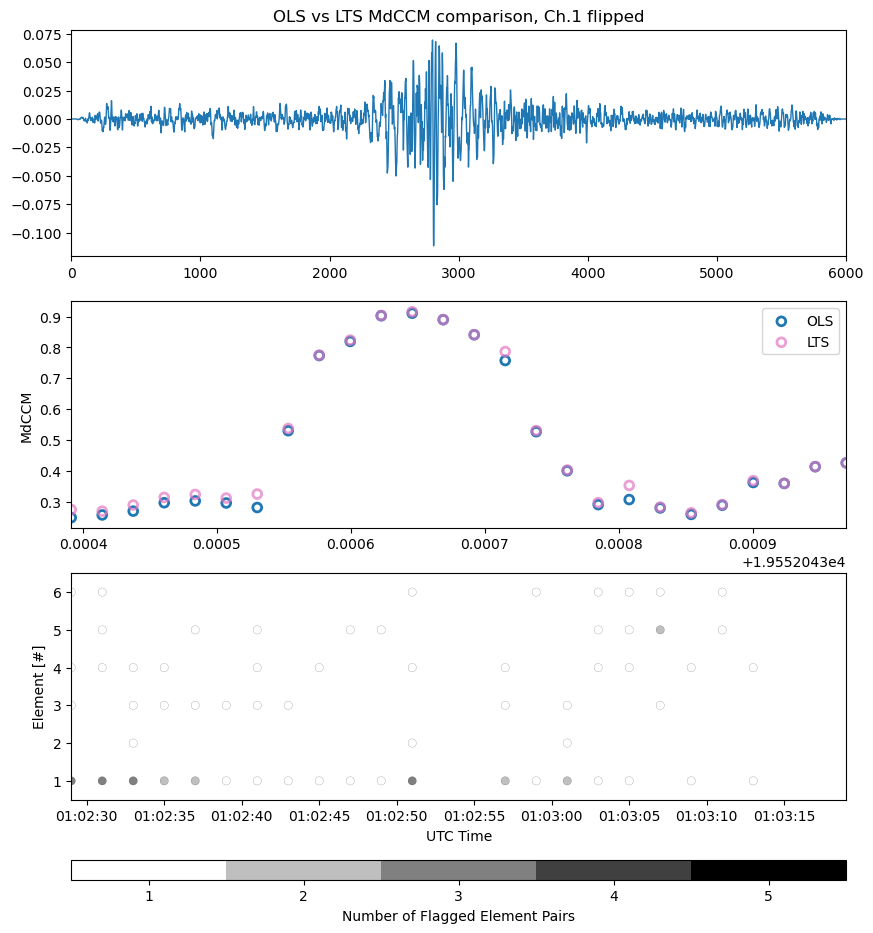

In [31]:
from collections import Counter
from copy import deepcopy

fig, axs = plt.subplots(nrows=3, figsize=(10,10))
t = ltsva2.t

#data
axs[0].plot(st[0], lw=1, label='Infrasound')
axs[0].set_xlim((0,len(st[0])))

line_w=2

#mccm
axs[1].scatter(t, ls2.mdccm, s=40,    facecolors='none', edgecolors='C0', linewidths=line_w, label='OLS' )
#axs[1].scatter(t, ls3.mdccm, s=60,    facecolors='none', edgecolors='C1', linewidths=line_w, label='3d LS' )
axs[1].scatter(t, ltsva2.mdccm, s=40, facecolors='none', edgecolors=cls[2], linewidths=line_w, label='LTS', alpha=0.7)
#axs[1].scatter(t, ltsva3.mdccm, s=20, facecolors='none', edgecolors='C3', linewidths=line_w, label='3d LTS')
axs[1].set_ylabel('MdCCM')
axs[1].set_xlim(t[0], t[-1])
axs[1].legend()

stdict = ltsva2.stdict
splot=2
if stdict is not None:
    ndict = deepcopy(stdict)
    n = ndict["size"]
    ndict.pop("size", None)
    tstamps = list(ndict.keys())
    tstampsfloat = [float(ii) for ii in tstamps]

    # Set the second colormap for station pairs.
    cm2 = plt.get_cmap("binary", (n - 1))
    initplot = np.empty(len(t))
    initplot.fill(1)

    axs[splot].scatter(np.array([t[0], t[-1]]), np.array([0.01, 0.01]), c="w")
    axs[splot].axis("tight")
    axs[splot].set_ylabel("Element [#]")
    axs[splot].set_xlabel("UTC Time")
    axs[splot].set_xlim(t[0], t[-1])
    axs[splot].set_ylim(0.5, n + 0.5)
    axs[splot].xaxis_date()
    axs[splot].tick_params(axis="x", labelbottom="on")

    # Loop through the stdict for each flag and plot
    for jj in range(len(tstamps)):
        z = Counter(list(ndict[tstamps[jj]]))
        keys, vals = z.keys(), z.values()
        keys, vals = np.array(list(keys)), np.array(list(vals))
        pts = np.tile(tstampsfloat[jj], len(keys))
        sc2 = axs[splot].scatter(
            pts,
            keys,
            c=vals,
            edgecolors="k",
            lw=0.1,
            cmap=cm2,
            vmin=0.5,
            vmax=n - 0.5,
        )

    # Add the horizontal colorbar for station pairs.
    p3 = axs[splot].get_position().get_points().flatten()
    p3 = axs[splot].get_position()
    cbaxes2 = fig.add_axes([p3.x0, p3.y0 - 0.08, p3.width, 0.02])
    hc2 = plt.colorbar(sc2, orientation="horizontal", cax=cbaxes2, ax=axs[splot])
    hc2.set_label("Number of Flagged Element Pairs")

axs[splot].xaxis_date()
axs[splot].set_xlabel("UTC Time")

axs[0].set_title("OLS vs LTS MdCCM comparison, Ch.1 flipped")

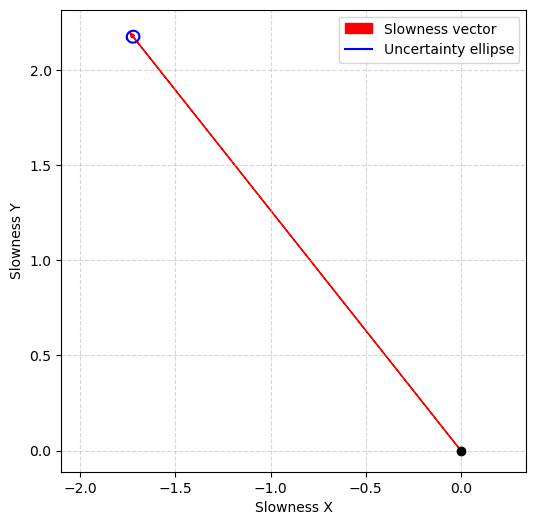

[[ 5.68566190e-05]
 [-1.06569331e-03]
 [ 3.43602153e-04]
 [-9.92495385e-04]
 [-5.08346139e-03]
 [-1.12254993e-03]
 [ 2.86745534e-04]
 [-1.04935200e-03]
 [-5.14031801e-03]
 [ 1.40929546e-03]
 [ 7.31979272e-05]
 [-4.01776807e-03]
 [-1.33609754e-03]
 [-5.42706354e-03]
 [-4.09096600e-03]]


In [5]:
#Visualize uncertainty ellipse for ltsva2 jj=10
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_uncertainty_ellipse(sx, sy, a, b, R, residuals=None):
    """
    Visualize slowness vector, residuals, and uncertainty ellipse.
    
    Parameters
    ----------
    sx, sy : float
        Slowness vector components.
    a, b : float
        Semi-major and semi-minor axes of the uncertainty ellipse.
    R : ndarray
        2x2 rotation matrix that orients the ellipse.
    residuals : ndarray, optional
        Residuals (errors), shape (N, 1) or (N,). If provided, they are plotted as text/hist.
    """

    fig, ax = plt.subplots(figsize=(6,6))

    # Plot slowness vector
    ax.plot(0, 0, 'ko')  # origin
    ax.arrow(0, 0, sx, sy, head_width=0.02, fc='r', ec='r', label="Slowness vector")

    # Build ellipse in rotated coordinates
    theta = np.linspace(0, 2*np.pi, 200)
    ellipse = np.vstack([a*np.cos(theta), b*np.sin(theta)])  # (2, N)
    ellipse_rot = R @ ellipse
    ellipse_rot = ellipse_rot.T + np.array([sx, sy])  # shift ellipse to (sx, sy)

    ax.plot(ellipse_rot[:,0], ellipse_rot[:,1], 'b-', label="Uncertainty ellipse")

    # Style
    ax.set_xlabel("Slowness X")
    ax.set_ylabel("Slowness Y")
    ax.legend()
    ax.axis("equal")
    ax.grid(True, linestyle="--", alpha=0.5)

    # If residuals are given, make a histogram alongside
    if residuals is not None:
        fig2, ax2 = plt.subplots()
        ax2.hist(residuals.flatten(), bins=20, edgecolor="k", alpha=0.7)
        ax2.set_xlabel("Residual (s)")
        ax2.set_ylabel("Count")
        ax2.set_title("Residual Distribution")

    plt.show()


sx, sy, a, b, R, res = ltsva2.sx, ltsva2.sy, ltsva2.a, ltsva2.b, ltsva2.R, ltsva2.residuals
plot_uncertainty_ellipse(sx, sy, a, b, R)
print(res)

In [5]:
print(ltsva3.lts_elev)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
